Esse notebook tem como objetivo o desenvolvimento do modelo Baseline de behavior solicitado pela claro para avaliar se clientes pré-pago virariam ou não inadimplentes ao migrar para plano controle.
Esse modelo irá utilizar todas as bases de dados disponíveis pela Claro(BUREAL + TELCO + Cadastro + booking recarga + booking pagamento + booking atraso)


#BIBLIOTECAS E INSTALAÇÕES

In [1]:
!apt-get update -qq > /dev/null
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
# manipulação, leitura e vizualização de dados bibiliotecas
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import numpy             as np

In [3]:
# Configurar o Pandas para não usar notação científica para floats e exibir com 2 casas decimais
pd.set_option('display.float_format', '{:.6f}'.format)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
#pd.reset_option('display.width')
#pd.reset_option('display.max_colwidth')

In [4]:
#machilne learning bibliotecas
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, FunctionTransformer
!pip install category_encoders
from category_encoders import TargetEncoder, WOEEncoder, CatBoostEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, auc
from sklearn.linear_model import LogisticRegression
!pip install catboost
import catboost as cb
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV, SelectKBest, f_classif, SelectFromModel
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 20.4 MB/s eta 0:00:00


#FUNÇÕES

In [5]:
# Criar variável para metadados
# (nomes das colunas, tipos, quantidade de nulos, percentual de nulos, cardinalidade)

def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes.astype(str), # Convert dtypes to string for sorting
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': ((dataframe.isnull().sum() / len(dataframe)) * 100).round(2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata = metadata.sort_values(by='tipo')
    metadata = metadata.reset_index(drop=True)

    return metadata

In [6]:
# Métricas do modelo

def calculate_metrics(nm_modelo, model, X_train, y_train, X_test, y_test):
    # Fazendo predições
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precisao': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })
    return metrics_df

def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [7]:
def plot_metrics(model, X_train, y_train, X_test, y_test, features):
    plt.figure(figsize=(15, 18))

    # Gráfico de Barras para Taxa do Evento e Importância das Variáveis
    plt.subplot(4, 2, 1)
    event_rate = y_train.mean()
    non_event_rate = 1 - event_rate
    plt.barh(['Não Evento', 'Evento'], [non_event_rate, event_rate], color=['lightsteelblue', 'skyblue'])
    plt.xlabel('Taxa')
    plt.title('Taxa do Evento')

    plt.subplot(4, 2, 2)
    importances = model.feature_importances_
    indices = np.argsort(importances)  # Ordem ascendente
    indices = indices[-10:]  # Considerando apenas as 10 mais importantes
    plt.barh(features[indices], importances[indices], color='skyblue')
    plt.xlabel('Importância')
    plt.title('Importância das Variáveis')

    # Curva ROC para Treino e Teste
    plt.subplot(4, 2, 3)
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')

    # Gráfico de Barras para Gini e KS
    plt.subplot(4, 2, 4)
    metrics = ['Índice Gini', 'Estatística KS']
    for X, y, label in [(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')]:
        probs = model.predict_proba(X)[:, 1]
        df = pd.DataFrame({'true_labels': y, 'predicted_probs': probs})
        df = df.sort_values(by='predicted_probs', ascending=False)
        df['cumulative_true'] = df['true_labels'].cumsum() / df['true_labels'].sum()
        df['cumulative_false'] = (1 - df['true_labels']).cumsum() / (1 - df['true_labels']).sum()
        ks = max(abs(df['cumulative_true'] - df['cumulative_false']))
        gini = 2 * auc(*roc_curve(y, probs)[:2]) - 1
        plt.bar([f'{label}\n{metric}' for metric in metrics], [gini, ks], color='skyblue')
    plt.title('Índice Gini e Estatística KS')

    # Matrizes de Confusão para Treino e Teste
    for i, (X, y, label) in enumerate([(X_train, y_train, 'Treino'), (X_test, y_test, 'Teste')], 5):
        plt.subplot(4, 2, i)
        conf_matrix = confusion_matrix(y, model.predict(X))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Matriz de Confusão - {label}')

    # Histograma do Score para Treino e Teste
    plt.subplot(4, 2, 7)
    plt.hist(model.predict_proba(X_train)[:, 1], bins=30, color='skyblue', edgecolor='black', alpha=0.7, label='Treino')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Treino')
    plt.legend(loc='upper right')

    plt.subplot(4, 2, 8)
    plt.hist(model.predict_proba(X_test)[:, 1], bins=30, color='lightsteelblue', edgecolor='black', alpha=0.7, label='Teste')
    plt.xlabel('Score')
    plt.ylabel('Frequência')
    plt.title('Histograma do Score - Teste')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [8]:
import sklearn.feature_selection

# Get a list of all attributes (modules, functions, classes) in sklearn.feature_selection
available_modules = dir(sklearn.feature_selection)

# Filter out private/internal attributes and print them
print("Available modules and functions in sklearn.feature_selection:")
for item in sorted(available_modules):
    if not item.startswith('_'): # Exclude private members
        print(f"- {item}")

Available modules and functions in sklearn.feature_selection:
- GenericUnivariateSelect
- RFE
- RFECV
- SelectFdr
- SelectFpr
- SelectFromModel
- SelectFwe
- SelectKBest
- SelectPercentile
- SelectorMixin
- SequentialFeatureSelector
- VarianceThreshold
- chi2
- f_classif
- f_oneway
- f_regression
- mutual_info_classif
- mutual_info_regression
- r_regression


In [9]:
def discretize_numeric_features(df, bins):
    df_discretized = df.copy()
    for col in df.columns:
        if df[col].dtype in ['float64', 'float32', 'int64', 'int32'] and len(df[col].unique()) > bins:
            df_discretized[col] = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
    return df_discretized

def calculate_iv(df, feature, target):
    lst = []
    for value in df[feature].unique():
        lst.append({
            'Value': value,
            'All': df[df[feature] == value].count()[feature],
            'Good': df[(df[feature] == value) & (df[target] == 1)].count()[feature],
            'Bad': df[(df[feature] == value) & (df[target] == 0)].count()[feature]
        })

    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = (dset['Good'] + 0.0001) / (dset['Good'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['Distr_Bad'] = (dset['Bad'] + 0.0001) / (dset['Bad'].sum() + 0.0001)  # Adding a small value to avoid division by zero
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad']).replace({np.inf: 0, -np.inf: 0})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    return dset['IV'].sum()

def classify_iv(iv_value):
    if iv_value < 0.02:
        return "Muito Fraco"
    elif iv_value < 0.1:
        return "Fraco"
    elif iv_value < 0.3:
        return "Moderado"
    elif iv_value < 0.5:
        return "Forte"
    else:
        return "Muito Forte"

# def select_features_by_iv_with_progress(df, target, iv_cutoff_ratio=1.0):
#     from tqdm import tqdm
#     iv_stats = []
#     for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
#         if col != target:
#             iv_value = calculate_iv(df, col, target)
#             iv_stats.append({
#                 'Variable': col,
#                 'IV': iv_value,
#                 'Predictiveness': classify_iv(iv_value)
#             })

#     iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
#     max_iv = iv_df['IV'].max()
#     cutoff_value = iv_cutoff_ratio * max_iv
#     selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

#     return selected_features, iv_df

def select_features_by_iv_discretized(df, target, iv_cutoff_ratio=1.0, bins=10):
    from tqdm import tqdm
    df = discretize_numeric_features(df, bins)

    iv_stats = []
    for col in tqdm(df.columns, desc="Calculating IV", unit="variable"):
        if col != target:
            iv_value = calculate_iv(df, col, target)
            iv_stats.append({
                'Variable': col,
                'IV': iv_value,
                'Predictiveness': classify_iv(iv_value)
            })

    iv_df = pd.DataFrame(iv_stats).sort_values(by='IV', ascending=False)
    max_iv = iv_df['IV'].max()
    cutoff_value = iv_cutoff_ratio * max_iv
    selected_features = iv_df[iv_df['IV'] >= cutoff_value]['Variable'].tolist()

    return selected_features, iv_df

In [10]:
# Função corrigida
def substituir_erros_para_nan(X, valores_errados_list):
    import pandas as pd
    import numpy as np
    X = pd.DataFrame(X)
    return X.replace(valores_errados_list, np.nan)

In [11]:
#conectando com google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# LEITURA E PADRONIZAÇÃO DA BASE DE DADOS

## Booking Pagamento

In [12]:
#lendo booking de variaveis criado a partir da base de recarga:
df_pagamento = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/book_pagamento_merged_combined.parquet')

In [13]:
#tamanho da tabela
df_pagamento.shape

(263709, 44)

In [14]:
#olhando algumas linhas da tabela:
df_pagamento.head(5)

,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO,QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,ID,FPD_SCORE,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,DAT_VENCIMENTO_CREDITO_MIN_STATUS_CREDITO_DIFF,DAT_VENCIMENTO_CREDITO_MIN_CRIACAO_CREDITO_DIFF,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO
0,384.110000,384.110000,54.799999,0.000000,0.000000,1.000000,0.000000,0.000000,54.870000,0.000000,777778UZTN8_202412,0,0.000000,0.000000,0.000000,0.000000,384.110000,54.870000,54.799999,4.000000,4.000000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,54.870000,54.870000,54.870000,54.870000,54.870000,0.000000,384.110000,384.110000,384.110000,384.110000,384.110000,384.110000,0.000000,384.110000,384.110000
1,455.900000,332.060000,30.590000,0.640000,442.000000,0.728361,618.000000,8.320000,35.070000,2271.110000,77777UZ9W87_202503,0,61.300000,30.590000,30.650000,30.590000,98.010000,32.670000,30.590000,-15.000000,-15.000000,394.500000,394.500000,394.500000,182.360000,182.260000,182.260000,182.260000,182.260000,36.450000,36.450000,36.450000,36.450000,36.470000,61.300000,358.600000,358.600000,296.160000,358.600000,358.700000,296.060000,30.650000,358.

In [15]:
generate_metadata(df_pagamento)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE,Int64,0,0.000000,2
1,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_P...,float32,0,0.000000,8711
2,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,float32,0,0.000000,9069
3,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESE...,float32,0,0.000000,10215
4,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATU...,float32,0,0.000000,9454
5,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_F...,float64,0,0.000000,76173
6,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLA...,float64,0,0.000000,88499
7,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLA...,float64,0,0.000000,88499
8,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_F...,float64,0,0.000000,12739
9,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_...,float64,0,0.000000,20155


## Booking Atraso

In [16]:
#lendo booking de variaveis criado a partir da base de recarga:
df_atraso = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO/book_atraso_merged_combined.parquet')

In [17]:
#tamanho da tabela
df_atraso.shape

(293815, 151)

In [18]:
#olhando algumas linhas da tabela:
df_atraso.head(5)

,QT_MAX_NUM_BILL_SEQ_FAT_ULTIMOS_12_MESES_ATRASO,QT_AVG_NUM_BILL_SEQ_FAT_ULTIMOS_12_MESES_ATRASO,QT_AVG_NUM_ENT_SEQ_FATURA_ULTIMOS_9_MESES_ATRASO,tendencia_fat_bruto_bc_3m_12m,QT_AVG_NUM_ENT_SEQ_FATURA_ULTIMOS_12_MESES_ATRASO,QT_MAX_NUM_ENT_SEQ_FATURA_ULTIMOS_12_MESES_ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_12_MESES_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_12_MESES_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_6_MESES_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_12_MESES_ATRASO,ID,FPD_SCORE,QT_DIAS_ENTRE_ATIVACAO_CONTA_CLI_E_DAT_REFERENCIA_MAX,QT_DIAS_ENTRE_ATIVACAO_CONTA_CLI_E_DAT_REFERENCIA_MIN,QT_DIAS_ALTERACAO_REGISTRO_TRANS,QT_DIAS_ENTRE_CRIACAO_REGISTRO_E_DAT_REFERENCIA_MAX,QT_DIAS_STATUS_FAT,QT_DIAS_ENTRE_CRIACAO_REGISTRO_E_DAT_REFERENCIA_MIN,QT_DIAS_MIN_VENCIMENTO_FAT,QT_DIAS_CRIACAO_FAT,QT_DIAS_ATIVACAO_CONTA_CLI,QT_DIAS_ENTRE_VENCIMENTO_FINAL_E_STATUS_MIN,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_MULTA_JUROS_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_ABERTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_BC_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MED_VAL_MULTA_JUROS_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_LIQUIDO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_S_IND_PRIMEIRA_FAT_ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IND_PRIMEIRA_FAT_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA__ATRASO,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_TOT_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA__ATRASO,VL_MED_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MIN_VAL_FAT_CREDITO_ULTIMOS_6_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_MED_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO,VL_TOT_VAL_FAT_BRUTO_ULTIMOS_12_MESES_FLAG_RANG

In [19]:
generate_metadata(df_atraso)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE,Int64,0,0.000000,2
1,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_12_MESES_FLAG_AUT...,float32,0,0.000000,13843
2,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IN...,float32,0,0.000000,11665
3,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_OTHE...,float32,0,0.000000,12572
4,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_N_IN...,float32,0,0.000000,23436
5,VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_O...,float32,0,0.000000,13450
6,VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLA...,float32,0,0.000000,5659
7,VL_MAX_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_OTHE...,float32,0,0.000000,22770
8,VL_MAX_VAL_FAT_CREDITO_ULTIMOS_3_MESES_FLAG_OT...,float32,0,0.000000,8334
9,VL_MIN_VAL_FAT_BRUTO_ULTIMOS_3_MESES_FLAG_AUTO...,float32,0,0.000000,13563


# CRIAÇÃO ABT para Modelagem

In [20]:
#lendo abt do modelo anterior(modelo 6):
df_abt = pd.read_parquet('/content/drive/MyDrive/bases_CLARO_CREDITO_abt_previa.parquet')

In [21]:
#repetindo processo com dados da base de atraso:
df_abt = df_abt.merge(df_atraso, on = 'ID', how = 'left') # temos dados para cerca de 300 mil clientes

In [22]:
#filtrando somente os clientes que não tem atraso:
df_abt = df_abt[df_abt['FPD_SCORE'].isna()]
df_abt.shape

(919633, 335)

### FEATURE ENGINEERING COM COLUNAS DE DATA DA BASE DE CADASTRO

In [23]:
df_abt['IDADE'] = (df_abt['SAFRA_DATA'] - df_abt['DATADENASCIMENTO']).dt.days / 365
df_abt['DIF_VAR_12_NASCIMENTO'] = (df_abt['var_12'] - df_abt['DATADENASCIMENTO']).dt.days
df_abt['DIF_VAR_12_SAFRA'] = (df_abt['SAFRA_DATA'] - df_abt['var_12']).dt.days

In [24]:
metadata_df = generate_metadata(df_abt)

# PREPARAÇÃO DOS DADOS

In [25]:
#eliminando as colunas com 70% de nulos:
missing_cutoff = 70
df_drop_nulos = metadata_df[(metadata_df['percent_nulos'] >= missing_cutoff)]
lista_drop_nulos = list(df_drop_nulos.nome_variavel.values)
lista_drop_nulos

['FPD_SCORE_y',
 'FPD_SCORE',
 'VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_12_MESES_FLAG_AUTOC_COD_PLATAFORMA__ATRASO',
 'VL_MAX_VAL_FAT_CREDITO_ULTIMOS_9_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO',
 'VL_MIN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_AUTOC_COD_PLATAFORMA_ATRASO',
 'VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA__ATRASO',
 'VL_MAX_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MIN_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MAX_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO',
 'VL_MEDIAN_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA__ATRASO',
 'VL_MIN_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MAX_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO',
 'VL_MAX_VAL_FAT_BRUTO_ULTIMOS_12_MESES_ATRAS

In [26]:
#detectando as colunas com 100% de nulos:
missing_cutoff_2 = 100
df_drop_nulos_2 = metadata_df[(metadata_df['percent_nulos'] >= missing_cutoff_2)]
lista_drop_nulos_2 = list(df_drop_nulos_2.nome_variavel.values)
lista_drop_nulos_2

['FPD_SCORE',
 'VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_12_MESES_FLAG_AUTOC_COD_PLATAFORMA__ATRASO',
 'VL_MAX_VAL_FAT_CREDITO_ULTIMOS_9_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO',
 'VL_MIN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_AUTOC_COD_PLATAFORMA_ATRASO',
 'VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA__ATRASO',
 'VL_MAX_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MIN_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MAX_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO',
 'VL_MEDIAN_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA__ATRASO',
 'VL_MIN_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO',
 'VL_MAX_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO',
 'VL_MAX_VAL_FAT_BRUTO_ULTIMOS_12_MESES_ATRASO',
 'VL_MAX_VAL

In [27]:
# Colunas que o missing significa ausência,ou seja, não devem ser deletadas
potenciais_colunas_para_manter = ['var_06', 'var_18', 'var_20', 'var_22', 'var_23'] + df_pagamento.columns.tolist() + df_atraso.columns.tolist()
colunas_para_manter = [col for col in potenciais_colunas_para_manter if col not in lista_drop_nulos_2]

# Filtrar a lista para remover as colunas que você quer manter
lista_drop_nulos = [col for col in lista_drop_nulos if col not in colunas_para_manter]


print(f"Colunas que serão removidas: {lista_drop_nulos}")

Colunas que serão removidas: ['FPD_SCORE_y', 'FPD_SCORE', 'VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_12_MESES_FLAG_AUTOC_COD_PLATAFORMA__ATRASO', 'VL_MAX_VAL_FAT_CREDITO_ULTIMOS_9_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA_ATRASO', 'VL_MIN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_AUTOC_COD_PLATAFORMA_ATRASO', 'VL_MEDIAN_VAL_FAT_CREDITO_ULTIMOS_12_MESES_FLAG_RANGE_261_265_DW_FAIXA_AGING_DIVIDA__ATRASO', 'VL_MAX_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO', 'VL_MIN_VAL_FAT_BRUTO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO', 'VL_MAX_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO', 'VL_MEDIAN_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT__ATRASO', 'VL_MEDIAN_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA__ATRASO', 'VL_MIN_VAL_FAT_CREDITO_ULTIMO_1_MES_FLAG_OTHERS_DW_HIS_PONTO_VENDA_COMTA_ATRASO', 'VL_MAX_VAL_FAT_BRUTO_ULTIMOS_6_MESES_FLAG_NEG_2_IND_ISENCAO_COB_FAT_ATRASO', 'VL_MAX_VAL_FAT_BRUTO_ULTIMO

In [28]:
#Colunas da base pagamento que vão para o modelo:
colunas_para_manter_base_pagamento_e_atraso = [col for col in colunas_para_manter if col in df_pagamento.columns or col in df_atraso.columns]
len(colunas_para_manter), len(colunas_para_manter_base_pagamento_e_atraso)

(49, 44)

In [29]:
colunas_para_manter_base_pagamento_e_atraso

['VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO',
 'VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO',
 'VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO',
 'VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO',
 'QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x',
 'TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO',
 'QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x',
 'VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO',
 'VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO',
 'QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x',
 'ID',
 'VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO',
 'VL_TOT_VAL_PAGAM

In [30]:
# retirando lista de variáveis com alto percentual de nulos que não seja da base pagamento nem da base de atraso
df_abt = df_abt.drop(axis=1,columns=lista_drop_nulos)
df_abt.shape

(919633, 177)

# MODELAGEM

In [31]:
#Metadados
generate_metadata(df_abt)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,FPD_SCORE_x,Int64,0,0.000000,2
1,SCORE_01,Int64,9966,1.080000,292
2,SCORE_02,Int64,857,0.090000,579
3,DATADENASCIMENTO,datetime64[ns],1654,0.180000,26129
4,SAFRA_DATA,datetime64[ns],0,0.000000,6
5,var_12,datetime64[ns],372017,40.450000,12025
6,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_P...,float32,911124,99.070000,2140
7,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATU...,float32,911124,99.070000,1628
8,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,float32,911124,99.070000,1935
9,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESE...,float32,911124,99.070000,1662


In [32]:
# Definir a data de corte para a divisão OOT (Out-of-Time)
# O teste será fevereiro e março de 2025, então o treino será antes de fevereiro de 2025.
cutoff_date = pd.to_datetime('2025-02-01')

# Dividir o dataset em treino e teste
df_abt_train = df_abt[df_abt['SAFRA_DATA'] < cutoff_date]
df_abt_test = df_abt[df_abt['SAFRA_DATA'] >= cutoff_date]

# Exibir o shape dos datasets resultantes para verificação
print(f"Shape do dataset de treino (df_treino): {df_abt_train.shape}")
print(f"Shape do dataset de teste (df_teste): {df_abt_test.shape}")

# Exibir as primeiras linhas de cada dataset para verificar as datas
print("\nPrimeiras linhas do dataset de treino:")
display(df_abt_train.head())
print("\nPrimeiras linhas do dataset de teste:")
display(df_abt_test.head())

Shape do dataset de treino (df_treino): (631811, 177)
Shape do dataset de teste (df_teste): (287822, 177)

Primeiras linhas do dataset de treino:


,NUM_CPF,SAFRA,FPD_SCORE_x,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO_x,FPD_x,PROD_x,flag_mig2_x,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,FLAG_INSTALACAO_y,FPD_y,PROD_y,flag_mig2_y,STATUSRF,DATADENASCIMENTO,var_03,var_04,var_05,var_06,var_09,var_12,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,evt_qtd_total,evt_qtd_30d,evt_qtd_60d,evt_qtd_90d,evt_share_30d,evt_share_60d,evt_share_90d,vida_ativa_dias,dias_desde_ultimo_evt,ritmo_medio_evt,gap_medio_evt_dias,share_evt_30d,share_evt_60d,share_evt_90d,ritmo_30d,gap_media_dias,gap_mediana_dias,gap_dp_dias,gap_min_dias,gap_max_dias,gap_p90_dias,share_gaps_le_1d,share_gaps_le_3d,share_gaps_le_7d,cv_gap_dias,burstiness_gap,evt_max_dia,evt_mean_dia,dias_ativos,ratio_pico_media,share_pico_total,flag_super_pico,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO,QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,DAT_VENCIMENTO_CREDITO_MIN_STATUS_CREDITO_DIFF,DAT_VENCIMENTO_CREDITO_MIN_CRIACAO_CREDITO_DIFF,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CRED


Primeiras linhas do dataset de teste:


,NUM_CPF,SAFRA,FPD_SCORE_x,SCORE_01,SCORE_02,SAFRA_DATA,ID,FLAG_INSTALACAO_x,FPD_x,PROD_x,flag_mig2_x,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,FLAG_INSTALACAO_y,FPD_y,PROD_y,flag_mig2_y,STATUSRF,DATADENASCIMENTO,var_03,var_04,var_05,var_06,var_09,var_12,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,CEP_3_digitos,evt_qtd_total,evt_qtd_30d,evt_qtd_60d,evt_qtd_90d,evt_share_30d,evt_share_60d,evt_share_90d,vida_ativa_dias,dias_desde_ultimo_evt,ritmo_medio_evt,gap_medio_evt_dias,share_evt_30d,share_evt_60d,share_evt_90d,ritmo_30d,gap_media_dias,gap_mediana_dias,gap_dp_dias,gap_min_dias,gap_max_dias,gap_p90_dias,share_gaps_le_1d,share_gaps_le_3d,share_gaps_le_7d,cv_gap_dias,burstiness_gap,evt_max_dia,evt_mean_dia,dias_ativos,ratio_pico_media,share_pico_total,flag_super_pico,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,QT_MIN_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,TEND__VAL_PAGAMENTO_FATURA_9_12_MESES_PAGAMENTO,QT_MIN_NUM_AGRUPADOR_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_JUROS_MULTAS_ITEM_ULTIMOS_12_MESES_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_PAGAMENTO,QT_AVG_SEQ_ARQUIVO_PAGAMENTO_ULTIMOS_12_MESES_PAGAMENTO_x,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MIN_VAL_PAGAMENTO_FATURA_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_MEDIAN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_FORMA_PAGAMENTO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,VL_MIN_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_NULL,DAT_VENCIMENTO_CREDITO_MIN_STATUS_CREDITO_DIFF,DAT_VENCIMENTO_CREDITO_MIN_CRIACAO_CREDITO_DIFF,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_B_COD_TIPO_FATURA_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_CREDITO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ORIGINAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_BAIXA_ATIVIDADE_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_ATUAL_PAGAMENTO_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_MED_VAL_PAGAMENTO_FATURA_ULTIMOS_6_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_NULL_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CREDITO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_BAIXA_ATIVIDADE_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_9_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_ATUAL_PAGAMENTO_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_FATURA_ULTIMOS_12_MESES_FLAG_PYM_COD_ALOCACAO_CREDITO_PAGAMENTO,VL_TOT_VAL_PAGAMENTO_CRED

In [33]:
#declarando x e y
X_train = df_abt_train.drop(columns=['NUM_CPF','SAFRA','FPD_SCORE_x','SAFRA_DATA','ID','FLAG_INSTALACAO_x','FLAG_INSTALACAO_y','FPD_x','FPD_y','PROD_x','PROD_y','flag_mig2_x','flag_mig2_y','DATADENASCIMENTO','var_12'],axis = 1)
y_train = df_abt_train['FPD_SCORE_x'].reset_index(drop=True)
X_test = df_abt_test.drop(columns=['NUM_CPF','SAFRA','FPD_SCORE_x','SAFRA_DATA','ID','FLAG_INSTALACAO_x','FLAG_INSTALACAO_y','FPD_x','FPD_y','PROD_x','PROD_y','flag_mig2_x','flag_mig2_y','DATADENASCIMENTO','var_12'],axis = 1)
y_test = df_abt_test['FPD_SCORE_x'].reset_index(drop=True)

In [34]:
#definindo tipos de colunas em listas para preprocessamento dos dados

booking_features = [col for col in colunas_para_manter_base_pagamento_e_atraso if col not in ['FPD_SCORE','ID']]

binary_features = X_train[['var_06','var_18','var_19','var_20','var_21','var_22','var_23','flag_super_pico']].columns.tolist()


numerical_features = [col for col in X_train.select_dtypes(exclude=['object', 'datetime64[ns]']).columns
                     if col not in binary_features and col not in booking_features and col not in ['SCORE_01', 'SCORE_02']]

categorical_features = [col for col in X_train.select_dtypes(include=['object']).columns
                       if col not in binary_features]

score_features = ['SCORE_01', 'SCORE_02'] # para garantir reprodutibilidade


print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features : {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"booking_features: {booking_features}")
print(f"booking_features: {score_features}")

Numerical Features: ['var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_43', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_68', 'var_69', 'var_70', 'var_71', 'var_72', 'var_81', 'var_82', 'var_89', 'var_90', 'evt_qtd_total', 'evt_qtd_30d', 'evt_qtd_60d', 'evt_qtd_90d', 'evt_share_30d', 'evt_share_60d', 'evt_share_90d', 'vida_ativa_dias', 'dias_desde_ultimo_evt', 'ritmo_medio_evt', 'gap_medio_evt_dias', 'share_evt_30d', 'share_evt_60d', 'share_evt_90d', 'ritmo_30d', 'gap_media_dias', 'gap_mediana_dias', 'gap_dp_dias', 'gap_min_dias', 'gap_max_dias', 'gap_p90_dias', 'share_gaps_le_1d', 'share_gaps_le_3d', 'share_gaps_le_7d', 'cv_gap_dias', 'burstiness_gap', 'evt_max_dia', 'evt_mean_dia', 'd

In [35]:
# Tratamento e Preparação dos Dados

# Define pipeline de data prep para variáveis numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # Como existe muita incerteza sobre variaveis, melhor imputar com a mediana
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

# Define pipeline de data prep para variáveis categoricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', CatBoostEncoder()) # aumentou a performance em relacao a target e WOE
])

# Define pipeline de data prep para variáveis categoricas
#binary_pipeline = Pipeline([
 #   ('passthrough', 'passthrough')  # Não faz nada, apenas passa os dados
# Define pipeline de data prep para variáveis categoricas
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),#nessas variaveis o missing representa ausência
    ('encoder', OneHotEncoder()) #estrategia para categoricas binarias
])

booking_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),#nessas variaveis o missing representa ausência
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

# Define a named function for converting to Int64Dtype
def convert_to_int64(X):
    return pd.DataFrame(X).astype(pd.Int64Dtype())

# Lista de valores outliers da variáveis SCORE01 E SCORE 02 que foram considerados erro da base
# Transformador para conversão de tipo (object → int)
t_int = FunctionTransformer(convert_to_int64, validate=False, feature_names_out='one-to-one')
valores_errados = [0,1,2]  # Exemplo: substitua pelos seus
# Criando o pipeline com 3 etapas:
score_pipeline = Pipeline([
    ('to_int', t_int), #transformando para int uma vez que o dados original é object (reprodutibilidade)
    ('corrigir_erros', FunctionTransformer(substituir_erros_para_nan, validate=False, feature_names_out='one-to-one', kw_args={'valores_errados_list': valores_errados})), #transformand bad data em missing antes do imputer(repodutibilidade)
    ('imputer', SimpleImputer(strategy='median')),  # Mantendo estratégia testada, uma vez que essa categoria é só para garantir reprodutibilidade
    ('scaler', StandardScaler()) # Normalizando as features numéricas para não ter problema de escala
])

In [36]:
# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, categorical_features),
    ('bi', binary_pipeline, binary_features),
    ('num', num_pipeline, numerical_features),
    ('pag', booking_pipeline, booking_features),
    ('sco', score_pipeline,score_features)
])

# Esta opção seleciona características baseadas na importância calculada pelo RandomForest
rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=0),
    threshold=-np.inf,  # Não usar threshold
    max_features=20
)

# Encapsulamento do Preprocessador e Feature Selector em um Pipeline
preprocesssor = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("feature_selection", rf_selector)
])

In [37]:
# Aplicação do Pré-processamento e Feature Selection aos Dados de Treino e teste

# Step 1: Apply fit_transform to X_train and transform to X_test
# This will return NumPy arrays with the selected features.
X_train_processed_raw = preprocesssor.fit_transform(X_train, y_train)
X_test_processed_raw = preprocesssor.transform(X_test)

# Step 2: Get the names of the selected features.
# The 'preprocesssor' is a Pipeline with two steps: 'preprocessor' (ColumnTransformer) and 'feature_selection' (SelectFromModel).
column_transformer_step = preprocesssor.named_steps['preprocessor']
feature_selector_step = preprocesssor.named_steps['feature_selection']

# Get the feature names generated by the ColumnTransformer BEFORE selection.
# This requires `column_transformer_step` to be fitted, which it is, implicitly,
# by `preprocesssor.fit_transform`.
ct_output_feature_names = column_transformer_step.get_feature_names_out()

# Get the mask for the selected features from the feature selector.
# This mask applies to the features in `ct_output_feature_names`.
selected_features_mask = feature_selector_step.get_support()

# Apply the mask to the ColumnTransformer's output feature names
selected_feature_names = ct_output_feature_names[selected_features_mask].tolist()

# Step 3: Create Pandas DataFrames using the raw processed arrays and the correct selected feature names.
# Explicitly cast to float to ensure all columns are numerical.
X_train_processed = pd.DataFrame(X_train_processed_raw, columns=selected_feature_names).astype(float)
X_test_processed = pd.DataFrame(X_test_processed_raw, columns=selected_feature_names).astype(float)

# Optional: Check if any object columns remain
object_columns_train = X_train_processed.select_dtypes(include=['object']).columns
object_columns_test = X_test_processed.select_dtypes(include=['object']).columns

if len(object_columns_train) > 0 or len(object_columns_test) > 0:
    print(f"AVISO: Colunas 'object' ainda presentes no X_train_processed: {list(object_columns_train)}")
    print(f"AVISO: Colunas 'object' ainda presentes no X_test_processed: {list(object_columns_test)}")
else:
    print("Todos os tipos de colunas são numéricos nos DataFrames processados.")
# Visualização das características selecionadas e suas importâncias (opcional)
if hasattr(feature_selector_step, 'estimator_'):
    # The feature_importances_ are from the underlying RandomForestClassifier.
    # These importances correspond to the features *before* SelectFromModel applied its final transformation,
    # i.e., the features output by the ColumnTransformer.
    importances_full_ct_features = pd.Series(
        feature_selector_step.estimator_.feature_importances_,
        index=ct_output_feature_names
    )
    # Now, filter these importances to show only for the selected features
    importances_selected = importances_full_ct_features[selected_feature_names].sort_values(ascending=False)
    print("Top 20 características mais importantes (após seleção):")
    print(importances_selected.head(20))

Todos os tipos de colunas são numéricos nos DataFrames processados.
Top 20 características mais importantes (após seleção):
num__dias_desde_ultimo_evt   0.050645
num__evt_qtd_90d             0.042289
sco__SCORE_02                0.036994
num__gap_max_dias            0.028705
num__evt_qtd_60d             0.026056
num__gap_dp_dias             0.019653
num__evt_share_90d           0.019065
num__share_evt_90d           0.018554
num__burstiness_gap          0.018431
num__cv_gap_dias             0.017961
sco__SCORE_01                0.017920
num__share_evt_60d           0.017269
num__evt_share_60d           0.016749
num__ritmo_30d               0.016313
cat__19                      0.014096
num__share_pico_total        0.013894
num__evt_share_30d           0.013882
cat__21                      0.013738
num__gap_p90_dias            0.013591
num__share_evt_30d           0.013001
dtype: float64


In [38]:
#adicinando segundo criterio de feature selection após a arvore
y_train.name = 'FPD_SCORE_x' # Ensure y_train has a name matching the original column
df_for_iv = X_train_processed.copy()
df_for_iv = pd.concat([df_for_iv, y_train], axis=1)

# Testing the function using a binarized version of the iris dataset
selected_vars_iv, iv_data = select_features_by_iv_discretized(df_for_iv, y_train.name, bins=10)
selected_vars_iv
iv_data

Calculating IV: 100%|██████████| 21/21 [00:09<00:00,  2.19variable/s]


,Variable,IV,Predictiveness
19,sco__SCORE_02,0.482270,Forte
18,sco__SCORE_01,0.316261,Forte
13,num__gap_max_dias,0.206069,Moderado
16,num__burstiness_gap,0.194226,Moderado
12,num__gap_dp_dias,0.162397,Moderado
7,num__dias_desde_ultimo_evt,0.135437,Moderado
17,num__share_pico_total,0.134526,Moderado
14,num__gap_p90_dias,0.112861,Moderado
15,num__cv_gap_dias,0.071679,Fraco
4,num__evt_share_30d,0.034355,Fraco


In [39]:
#selecionando somente variáveis com pelo menos poder moderado de predição:
cut_off_iv = ['Muito Forte','Forte','Moderado']

# Filtrar iv_data para obter as variáveis com predictiveness desejada
final_selected_features = iv_data[iv_data['Predictiveness'].isin(cut_off_iv)]['Variable'].tolist()

# Usar a lista de variáveis selecionadas para filtrar X_train_processed e X_test_processed
X_train_processed = X_train_processed[final_selected_features]
X_test_processed = X_test_processed[final_selected_features]

In [40]:
X_train_processed

,sco__SCORE_02,sco__SCORE_01,num__gap_max_dias,num__burstiness_gap,num__gap_dp_dias,num__dias_desde_ultimo_evt,num__share_pico_total,num__gap_p90_dias
0,0.179921,-0.417426,0.251625,-1.309890,1.275574,0.121220,0.191558,1.789159
1,-1.107133,-0.733298,0.538892,0.766758,-0.082253,-0.390617,0.032191,-0.678801
2,1.423347,0.747351,-1.357068,0.013374,-0.311508,5.712056,4.574160,-0.920758
3,0.648933,0.510447,-0.638902,0.239807,-0.479171,0.239336,-0.622601,-0.291670
4,0.169014,0.609157,-0.926168,0.277922,-0.665574,0.278709,-0.426397,-0.340061
...,...,...,...,...,...,...,...,...
631806,1.052501,0.885545,-1.098528,0.112881,-1.258099,-0.390617,-1.047089,-1.211106
631807,-0.681751,-0.989944,0.768705,0.469433,0.312656,0.475569,-0.245417,0.192244
631808,-0.845359,0.293285,-1.041075,-0.243761,-0.777915,-0.626849,-0.959428,-0.388452
631809,0.408973,0.115607,-0.523995,-0.072539,-0.180588,-0.311873,-0.432990,0.385809


In [41]:
# Testar principais modelos de machile learning para problemas de classificacao apenas modificando o parametro
# que ajuda em trabalhar com classes desbalanceadas

# Calculate scale_pos_weight
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight_value = count_neg / count_pos

algoritmos = [DecisionTreeClassifier(random_state=0, class_weight='balanced',max_depth = 5),
              LogisticRegression(random_state=0,class_weight='balanced'),
              RandomForestClassifier(random_state=0, class_weight='balanced',max_depth= 5),
              GradientBoostingClassifier(random_state=0,max_depth=5),
              #XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value,gpu_id='0',tree_method='gpu_hist'),
              XGBClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value,max_depth= 5),
              #lgb.LGBMClassifier(random_state=0,is_unbalance=True,gpu_id='0',tree_method='gpu_hist'),
              lgb.LGBMClassifier(random_state=0,is_unbalance=True,max_depth= 5),
              cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0, max_depth=5)
              #cb.CatBoostClassifier(random_state=0, scale_pos_weight=scale_pos_weight_value, verbose=0, task_type='GPU')
              ]

for algoritmo in algoritmos:

    nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
    # Treino do modelo
    algoritmo.fit(X_train_processed,y_train)

    # Avaliar modelo
    metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
    display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,DecisionTreeClassifier,Treino,0.696895,0.411736,0.721110,0.770469,0.540938,0.410895
1,DecisionTreeClassifier,Teste,0.631241,0.315615,0.546938,0.651761,0.303522,0.239627


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.672079,0.385698,0.702468,0.746325,0.492650,0.365896
1,LogisticRegression,Teste,0.645732,0.344562,0.636908,0.694407,0.388814,0.286445


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,RandomForestClassifier,Treino,0.698957,0.415731,0.740648,0.786497,0.572995,0.427230
1,RandomForestClassifier,Teste,0.649787,0.343982,0.613605,0.688560,0.377120,0.276127


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,GradientBoostingClassifier,Treino,0.825212,0.720031,0.400964,0.841733,0.683466,0.515437
1,GradientBoostingClassifier,Teste,0.748456,0.392430,0.215350,0.663351,0.326701,0.237008


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,XGBClassifier,Treino,0.757184,0.484718,0.773435,0.848390,0.696780,0.526011
1,XGBClassifier,Teste,0.632540,0.320876,0.567215,0.654914,0.309828,0.223870


[LightGBM] [Info] Number of positive: 146280, number of negative: 485531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1902
[LightGBM] [Info] Number of data points in the train set: 631811, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.231525 -> initscore=-1.199721
[LightGBM] [Info] Start training from score -1.199721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LGBMClassifier,Treino,0.750365,0.475847,0.770509,0.842126,0.684251,0.515151
1,LGBMClassifier,Teste,0.638273,0.326855,0.573685,0.662539,0.325079,0.235455


,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,<catboost.core.CatBoostClassifier object at 0x...,Treino,0.765237,0.495533,0.775861,0.855579,0.711158,0.538158
1,<catboost.core.CatBoostClassifier object at 0x...,Teste,0.636470,0.321571,0.554922,0.652865,0.305730,0.220071


Como nesse problema o principal foco é o indicador KS, a regressão logistica teve o melhor desempenho nesse caso, não só por performance mas também por estabilidade do resultado pois métrica de treino e teste tem o menor gap em relação as demais

## Tunagem de hiperparâmetros

In [42]:
#bibiloteca para fazer tunagem de hiperparametros

OPTUNA_EARLY_STOPING = 10

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

In [43]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# Função objetivo para otimização com Optuna
def objective(trial):
    # Hiperparâmetros da Regressão Logística
    param = {
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "C": trial.suggest_float("C", 1e-4, 100.0, log=True),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "max_iter": 1000,
        "random_state": 0
    }

    # Compatibilidade entre penalty e solver
    if param["penalty"] == "l1" and param["solver"] not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()
    if param["penalty"] == "l2" and param["solver"] not in ["liblinear", "saga"]:
        raise optuna.exceptions.TrialPruned()

    cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    avg_ks = 0

    for i, (tr, ts) in enumerate(cv.split(X_train_processed, y_train)):
        Xtr, Xvl = X_train_processed.iloc[tr], X_train_processed.iloc[ts]
        ytr, yvl = y_train.iloc[tr], y_train.iloc[ts]

        model = LogisticRegression(**param)
        model.fit(Xtr, ytr)
        p = model.predict_proba(Xvl)[:, 1]

        # Cálculo do KS
        df_temp = pd.DataFrame({'true_labels': yvl, 'predicted_probs': p})
        df_temp = df_temp.sort_values(by='predicted_probs', ascending=False)

        total_true = df_temp['true_labels'].astype(float).sum()
        total_false = (1 - df_temp['true_labels'].astype(float)).sum()

        cumulative_true = df_temp['true_labels'].astype(float).cumsum() / total_true if total_true > 0 else 0
        cumulative_false = (1 - df_temp['true_labels'].astype(float)).cumsum() / total_false if total_false > 0 else 0

        ks_statistic = max(abs(cumulative_true - cumulative_false))
        print(f"Fold {i+1} KS: {ks_statistic}")
        avg_ks += ks_statistic

    avg_ks /= 5
    print(f"Total avg_ks: {avg_ks}")
    return avg_ks

#executando treinamento:

# Criação do estudo
study = optuna.create_study(
    direction="maximize",
    study_name="logistic_regression_ks",
    storage="sqlite:///logistic_regression_ks.db",
    load_if_exists=True
)

# Adiciona trials anteriores (opcional)
study.add_trials(study.trials)

# Otimização com early stopping (se definido)
try:
    study.optimize(objective, timeout=7200, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f"EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}")

# Resultados
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2026-02-09 19:15:32,505] A new study created in RDB with name: logistic_regression_ks


Fold 1 KS: 0.3677049572854747
Fold 2 KS: 0.36516603395342984
Fold 3 KS: 0.36373651914066024
Fold 4 KS: 0.3635321616383161


[I 2026-02-09 19:15:39,452] Trial 0 finished with value: 0.3641651191204783 and parameters: {'penalty': 'l2', 'C': 0.0009190609021862409, 'solver': 'liblinear'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.3606859235845106
Total avg_ks: 0.3641651191204783
Fold 1 KS: 0.36755075566660295
Fold 2 KS: 0.36488837588749223
Fold 3 KS: 0.36351813948499767
Fold 4 KS: 0.36359563374109627


[I 2026-02-09 19:15:47,302] Trial 1 finished with value: 0.36407764613683546 and parameters: {'penalty': 'l2', 'C': 46.010381700894506, 'solver': 'liblinear'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.3608353259039885
Total avg_ks: 0.36407764613683546
Fold 1 KS: 0.36753475545479874
Fold 2 KS: 0.3649019608605107
Fold 3 KS: 0.36351813948499767
Fold 4 KS: 0.36360811766743384


[I 2026-02-09 19:16:05,538] Trial 2 finished with value: 0.36407273623374664 and parameters: {'penalty': 'l1', 'C': 0.36779024742649785, 'solver': 'liblinear'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.3608007077009925
Total avg_ks: 0.36407273623374664
Fold 1 KS: 0.3675301598290217
Fold 2 KS: 0.3649056849889901
Fold 3 KS: 0.3635225274798583
Fold 4 KS: 0.3635734994644379


[I 2026-02-09 19:16:28,950] Trial 3 finished with value: 0.3640721247539874 and parameters: {'penalty': 'l2', 'C': 35.08319913538295, 'solver': 'saga'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.3608287520076291
Total avg_ks: 0.3640721247539874
Fold 1 KS: 0.36752402141619056
Fold 2 KS: 0.3649019608605107
Fold 3 KS: 0.3635214264331774
Fold 4 KS: 0.3635691438533033


[I 2026-02-09 19:16:47,343] Trial 4 finished with value: 0.3640701554840979 and parameters: {'penalty': 'l1', 'C': 16.764681246056412, 'solver': 'liblinear'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.36083422485730754
Total avg_ks: 0.3640701554840979
Fold 1 KS: 0.36754045774781235
Fold 2 KS: 0.3649056849889901
Fold 3 KS: 0.3635225274798583
Fold 4 KS: 0.3635695810336031


[I 2026-02-09 19:17:12,493] Trial 5 finished with value: 0.36407546025654636 and parameters: {'penalty': 'l1', 'C': 2.9938906099132967, 'solver': 'saga'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.3608390500324679
Total avg_ks: 0.36407546025654636
Fold 1 KS: 0.3673960524571422
Fold 2 KS: 0.36442472189180025
Fold 3 KS: 0.3629117866010909
Fold 4 KS: 0.36323214260963865


[I 2026-02-09 19:17:36,906] Trial 6 finished with value: 0.36370531949479074 and parameters: {'penalty': 'l1', 'C': 0.00247540336947149, 'solver': 'saga'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.3605618939142818
Total avg_ks: 0.36370531949479074
Fold 1 KS: 0.36729984949410055
Fold 2 KS: 0.3643145200725344
Fold 3 KS: 0.3628964529068734
Fold 4 KS: 0.3631826440845879


[I 2026-02-09 19:17:52,073] Trial 7 finished with value: 0.3636512890654392 and parameters: {'penalty': 'l1', 'C': 0.0019880614670036204, 'solver': 'liblinear'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.36056297876909976
Total avg_ks: 0.3636512890654392
Fold 1 KS: 0.36754045774781235
Fold 2 KS: 0.36490897193716987
Fold 3 KS: 0.3635225274798583
Fold 4 KS: 0.36358533571625745


[I 2026-02-09 19:18:00,227] Trial 8 finished with value: 0.36407409690168563 and parameters: {'penalty': 'l2', 'C': 0.3321902795920449, 'solver': 'liblinear'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.36081319162733017
Total avg_ks: 0.36407409690168563
Fold 1 KS: 0.36755075566660295
Fold 2 KS: 0.3649056849889901
Fold 3 KS: 0.36351813948499767
Fold 4 KS: 0.3635695810336031


[I 2026-02-09 19:18:25,563] Trial 9 finished with value: 0.3640766422413323 and parameters: {'penalty': 'l1', 'C': 1.9919890976170171, 'solver': 'saga'}. Best is trial 0 with value: 0.3641651191204783.


Fold 5 KS: 0.3608390500324679
Total avg_ks: 0.3640766422413323
Fold 1 KS: 0.3673247632346694
Fold 2 KS: 0.36591735258636515
Fold 3 KS: 0.36485340146351125
Fold 4 KS: 0.3645500792947912


[I 2026-02-09 19:18:31,990] Trial 10 finished with value: 0.3647670465656976 and parameters: {'penalty': 'l2', 'C': 0.00010680332349043686, 'solver': 'liblinear'}. Best is trial 10 with value: 0.3647670465656976.


Fold 5 KS: 0.36118963624915107
Total avg_ks: 0.3647670465656976
Fold 1 KS: 0.3672534623964146
Fold 2 KS: 0.3658074746043583
Fold 3 KS: 0.36475003261041206
Fold 4 KS: 0.3646261486669498


[I 2026-02-09 19:18:39,323] Trial 11 finished with value: 0.364702740588028 and parameters: {'penalty': 'l2', 'C': 0.00011611590721654751, 'solver': 'liblinear'}. Best is trial 10 with value: 0.3647670465656976.


Fold 5 KS: 0.36107658466200515
Total avg_ks: 0.364702740588028
EarlyStopping Exceeded: No new best scores on iters 10
Number of finished trials: 12
Best trial:
  Value: 0.3647670465656976
  Params: 
    penalty: l2
    C: 0.00010680332349043686
    solver: liblinear


In [44]:
#treinando o modelo novamente, agora com os parametros achado pela biblioteca de otimizacao de hiperparametro:
algoritmo = LogisticRegression(**study.best_params,random_state = 0)

nome_algoritmo = str(algoritmo)[:str(algoritmo).find("(")]
# Treino do modelo
algoritmo.fit(X_train_processed,y_train)

# Avaliar modelo
metricas = calculate_metrics(nome_algoritmo,algoritmo, X_train_processed, y_train, X_test_processed, y_test)
display(metricas)

,Algoritmo,Conjunto,Acuracia,Precisao,Recall,AUC_ROC,GINI,KS
0,LogisticRegression,Treino,0.781158,0.595092,0.171404,0.745706,0.491411,0.364392
1,LogisticRegression,Teste,0.766241,0.444288,0.155540,0.692858,0.385716,0.284200


Insight: Ocorreu um pequeno ganho de estabilidade com otimização de hiperparametro

### Explicabilidade dos resultados

In [45]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Calculate the odds ratios first
odds_ratios = np.exp(algoritmo.coef_[0])

# Apply the conditional logic for 'Coeficiente interpretação'
# Multiply by 100 to get a percentage
interpreted_coefs = np.where(odds_ratios < 1, (1 - odds_ratios) * 100, (odds_ratios - 1) * 100)

# Cria a tabela com os coeficientes
coef_df = pd.DataFrame({
    'Variável': X_train_processed.columns,
    'Coeficiente': algoritmo.coef_[0],
    'Coeficiente interpretação': [f'{x:.1f}%' for x in interpreted_coefs]
})
# Ordena por ordem decrescente de impacto (opcional)
coef_df = coef_df.sort_values(by='Coeficiente', ascending=True)

# Exibe a tabela
print(coef_df)


                     Variável  Coeficiente Coeficiente interpretação
0               sco__SCORE_02    -0.512346                     40.1%
1               sco__SCORE_01    -0.142204                     13.3%
2           num__gap_max_dias     0.052968                      5.4%
4            num__gap_dp_dias     0.064974                      6.7%
5  num__dias_desde_ultimo_evt     0.086397                      9.0%
7           num__gap_p90_dias     0.194719                     21.5%
6       num__share_pico_total     0.202434                     22.4%
3         num__burstiness_gap     0.299661                     34.9%


INSIGHT:
- Variável score 02 é a mais significativa, a cada ponto a mais no score, probabilidade de ser inadimplenete cai 43%.
- No outro extremo, a a cada aumento na variavel burstiness, aumenta em 39% a probabilidade de ser inadimplente,
-  SIGNIFICADO DAS COLUNAS:
- gap_max dias = dias entre a primeira e última recarga
- gap_dp dias  = desvio padrão entre os dias de recarga
- dias desde ultimo evt = Dias desde a última recarga até a data de referência
- *share_pico_total* = Proporção do volume total concentrada no dia de pico.
- gap p.90 dias = dias entre a primeira recarga e a recarga percentil 90
- burstiness gap = Burstiness é uma medida estatística usada para descrever como os eventos se distribuem no tempo.
1) ≈ 0	O cliente faz recargas em blocos (ex: várias em poucos dias)
2) < 0	O cliente tem comportamento regular (ex: recarga todo mês)
3) > 0	O cliente tem comportamento irregular (ex: recargas imprevisíveis)



## Ordenação nos decis

### Treino

In [46]:
y_train.index = X_train_processed.index

bins = 10
tab = pd.concat([X_train_processed,y_train],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE_x']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE_x == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_train = table[['decile','event_rate','perc_total_bads']]
table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)
table_train

/tmp/ipython-input-1275218580.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_train.rename(columns={'event_rate':'event_rate_train','perc_total_bads':'perc_total_bads_train'},inplace=True)


,decile,event_rate_train,perc_total_bads_train
0,0,0.559701,0.241749
1,1,0.413495,0.178596
2,2,0.331524,0.143191
3,3,0.268752,0.116079
4,4,0.212580,0.091817
5,5,0.174388,0.075321
6,6,0.136497,0.058955
7,7,0.106029,0.045796
8,8,0.072965,0.031515
9,9,0.039316,0.016981


### Teste

In [47]:
y_test.index = X_test_processed.index

bins = 10
tab = pd.concat([X_test_processed,y_test],axis=1).copy()
tab['score'] = algoritmo.predict_proba(tab.drop(columns=['FPD_SCORE_x']))[:,0]
tab['decile'] = pd.qcut(tab['score'], bins, labels=False)

# Criar tabela detalhada
table = tab.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='mean'),
    volume=pd.NamedAgg(column='FPD_SCORE_x', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='FPD_SCORE_x', aggfunc=lambda x: (x == 1).sum()/tab[tab.FPD_SCORE_x == 1].shape[0])
).reset_index()
table['min_score'] = 1000*table['min_score']
table['max_score'] = 1000*table['max_score']
table_test = table[['decile','event_rate','perc_total_bads']]
table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)
table_test

/tmp/ipython-input-3200012293.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_test.rename(columns={'event_rate':'event_rate_test','perc_total_bads':'perc_total_bads_test'},inplace=True)


,decile,event_rate_test,perc_total_bads_test
0,0,0.435431,0.193545
1,1,0.365263,0.162350
2,2,0.315128,0.140066
3,3,0.271559,0.120701
4,4,0.228407,0.101521
5,5,0.196720,0.087437
6,6,0.163366,0.072612
7,7,0.128205,0.056984
8,8,0.092593,0.041155
9,9,0.053156,0.023628


In [48]:
summary = pd.merge(table_train,table_test,on='decile',how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.559701,0.241749,0.435431,0.193545
1,1,0.413495,0.178596,0.365263,0.162350
2,2,0.331524,0.143191,0.315128,0.140066
3,3,0.268752,0.116079,0.271559,0.120701
4,4,0.212580,0.091817,0.228407,0.101521
5,5,0.174388,0.075321,0.196720,0.087437
6,6,0.136497,0.058955,0.163366,0.072612
7,7,0.106029,0.045796,0.128205,0.056984
8,8,0.072965,0.031515,0.092593,0.041155
9,9,0.039316,0.016981,0.053156,0.023628


Insight:
- No geral, o modelo anterior é um pouco melhor que o atual e um pouco mais estável. Isso se deve devido a diminuição da base treino e teste pois as demais variáveis da modelagem se repetem.


### Visualização Gráfica

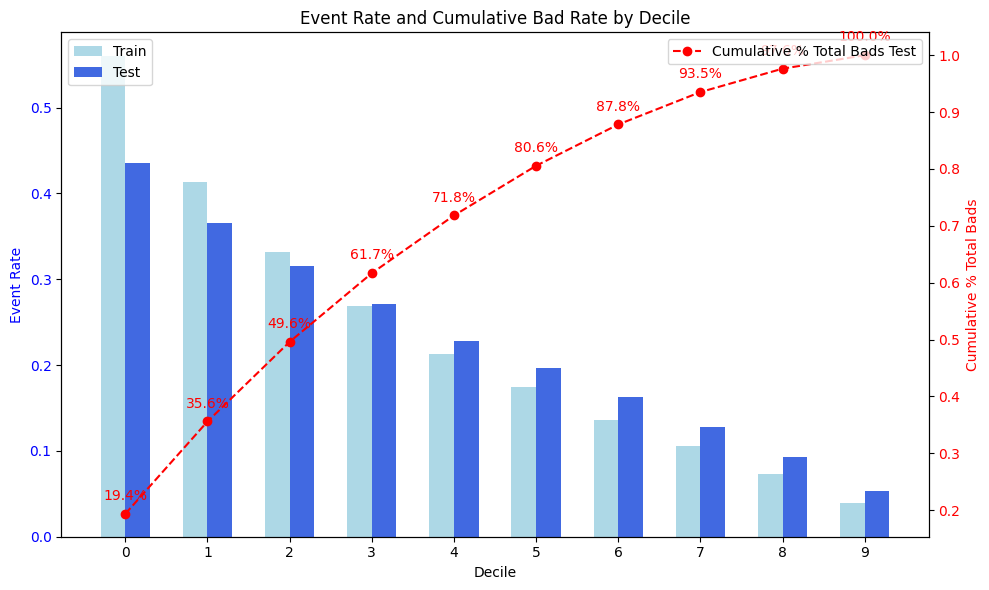

In [49]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
ax1.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

ax1.set_xlabel('Decile')
ax1.set_ylabel('Event Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Event Rate and Cumulative Bad Rate by Decile')
ax1.set_xticks([r + barWidth / 2 for r in range(len(summary))])
ax1.set_xticklabels(summary['decile'])
ax1.legend(loc='upper left')

# Calculate cumulative sum for perc_total_bads_test
summary['cumulative_perc_total_bads_test'] = summary['perc_total_bads_test'].cumsum()

# Create a second y-axis for the cumulative sum
ax2 = ax1.twinx()
ax2.plot([r + barWidth / 2 for r in range(len(summary))], summary['cumulative_perc_total_bads_test'], color='red', marker='o', linestyle='--', label='Cumulative % Total Bads Test')
ax2.set_ylabel('Cumulative % Total Bads', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

# Add percentage labels to the cumulative bad rate line
for i, (x, y) in enumerate(zip([r + barWidth / 2 for r in range(len(summary))], summary['cumulative_perc_total_bads_test'])):
    ax2.annotate(f'{y:.1%}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='red')

fig.tight_layout()
plt.show()

Insight final:
- No geral, o modelo anterior é um pouco melhor que o atual e um pouco mais estável. Isso se deve devido a diminuição da base treino e teste pois as demais variáveis da modelagem se repetem.
- O Modelo diminuiu em 0.006 pontos o KS.
- Devido limitação da base de dados total, foi possível treinar o modelo com toda as linhas da base de dados disponíveis.
- Esse será o modelo Baseline para os clientes sem histórico de dados de atraso enquanto terá outro para cliente com histórico de atraso,  essa estatégica é mais performatica do que colocar toda base em um único modelo.
- Considerando a performance e o KS atual, o modelo melhorou mas ainda não atende as métricas de meta, uma vez que valor é menor considerando o benchmarking de mercado e também está bem menor em relação ao modelo atual da claro(KS=33.1).

Tentativas de otimização de performance:
- Aumento de % amostral para treinamento, mais que o atual não é suportado pelo Colab de 0,1 para 0,3, ganhando +-0.005 de ks
- Adicionado no feature selection o modelo IV após seleção via random forest, reduzindo de 20 para 8 features e elevando o ks em +-0.02

## Salvar melhor modelo

In [50]:
import pickle
#Pickle variaveis do modelo:
with open('/content/drive/MyDrive/bases_CLARO_CREDITO/vars_baseline_sem_atraso.pkl', 'wb') as f:
    pickle.dump(X_train_processed.columns, f)

# Salvar o preparação dos dados:
with open('/content/drive/MyDrive/bases_CLARO_CREDITO/preprocessor_baseline_sem_atraso.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

#Pickle configuração modelo treinado:
with open('/content/drive/MyDrive/bases_CLARO_CREDITO/clf_baseline_sem_atraso.pkl', 'wb') as file:
  pickle.dump(algoritmo, file)